In [2]:
%load_ext autoreload
%autoreload 2
import sys

sys.path.append('B://workspace/tensorflow')

import numpy as np

from torch.utils.data import DataLoader, random_split

from src.models.RDF import RDFNetwork
from src.dataset.Argo import Argo3DTemperatureDataset
from src.config.params import Areas

In [3]:
from src.plot.sst import _range
from src.dataset.Argo import depthMap
from src.config.constants import Alphabet

def get_lon(lon):
    lon_s = 360 + lon[0] if lon[0] < 0 else lon[0]
    lon_e = 360 + lon[1] if lon[1] < 0 else lon[1]
    
    print(lon_s, lon_e)
    
    return [lon_s, lon_e]

def get_lat(lat):
    return lat + 80

def split_dataset(area):
    dataset = Argo3DTemperatureDataset(lon=get_lon(np.array(area['lon'])), lat=get_lat(np.array(area['lat'])), depth=[0, 58])

    train_dataset, val_dataset, test_dataset = random_split(dataset, [0.8, 0.1, 0.1])
    
    train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    return train_loader, val_loader, test_loader

def get_input(loader):
    input, output = next(iter(loader))
    input = input.reshape(-1, input.shape[-1])
    output = output.reshape(-1, output.shape[-1])
    return input, output

def train_and_evaluate(input, output, test_input, test_output, model):
    model.fit(input, output)
    score = model.score(test_input, test_output)
    score = np.around(score, 3)
    return model, score

def rmse(pred, true):
    true = true.numpy()
    rmses = []
    
    for i in range(58):
        pred_temp = pred[:, i].reshape(20, 20)
        true_temp = true[:, i].reshape(20, 20)
        mse = np.nanmean((pred_temp - true_temp) ** 2)
        rmse = np.sqrt(mse)
        rmses.append(rmse)
        
    # 计算 1000dbr 以上的 RMSE
    rmses_1000u = rmses[:45]
    # 计算 1000dbr 以下的 RMSE
    rmses_1000d = rmses[45:]
    
    return np.nanmean(rmses_1000u), np.nanmean(rmses_1000d)

def reshape(data):
    data[data > 99] = np.nan
    return data.reshape(20, 20, 58)

def profile_u(data):
    return np.transpose(data[10, :, :35], (1, 0))


def plot_sst_station(profile, ax, levels, label, lat, ylabel=True):
    
    if ylabel:
        # 将 depth 设置为 Y 轴刻度
        ax.set_yticks(np.arange(0, len(depthMap[:35]), 10))
        ax.set_yticks(np.arange(0, len(depthMap[:35]), 5), minor=True)
        # 设置对应的深度值标签
        ax.set_yticklabels(depthMap[:35][::10])
    else:
        ax.axes.yaxis.set_ticklabels([])
    
    # 设置 X 轴刻度，2004年1月到2024年3月
    ax.set_xticks(np.arange(0, 20, 4))
    # 设置小刻度
    xticks_labels = [f"{x:.0f}°N" if x >= 0 else f"{abs(x):.0f}°S" for x in _range(lat, 4)]
    ax.set_xticks(np.arange(0, 20, 1), minor=True)
    ax.set_xticklabels(xticks_labels)
    
    # 修改文本位置到左上角，使用相对坐标
    ax.text(0.02, 0.12, label, 
            fontsize=8, 
            color='orange',
            transform=ax.transAxes,  # 使用相对坐标系统
            verticalalignment='bottom'
    )

    ax.contourf(profile, levels=levels)
    ax.contour(profile, colors='black', alpha=0.5, linewidths=0.2, linestyles='--', levels=30)
    contour_lines = ax.contour(profile, colors='black', linewidths=0.5)
    
    ax.clabel(contour_lines, inline=True, colors='black', fontsize=5, fmt='%d', manual=False)
        
    ax.invert_yaxis()


In [5]:
# ---- 实验 1： 同时选取所有研究区域中的任意一个观测点，观察模型剖面预测效果  ----

list = []
modules = []

for area in Areas:
    network = RDFNetwork()
    model = network.get_model()
    train_loader, val_loader, test_loader = split_dataset(area)

    input, output = get_input(train_loader)
    val_input, val_output = get_input(val_loader)
    train_and_evaluate(input, output, val_input, val_output, model)
    
    modules.append(model)


200 220


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   44.9s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  3.0min
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:  6.8min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    3.8s


220 240


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   43.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  2.9min
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:  6.6min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    3.4s


70 90


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   35.9s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  2.4min
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:  5.5min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    2.4s


320 340


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   46.9s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  3.2min
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:  7.1min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    3.6s


200 220


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Area: a), RMSE: 336.6450566113777, 7070.645600761605 
            origin: max = 24.972700119018555, min = 1.9873000383377075 
            predict: max = 24.97409440612793, min = 3.6104412398338317
220 240


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Area: b), RMSE: 557.5412655781586, 6911.344737543745 
            origin: max = 26.268600463867188, min = 2.0264999866485596 
            predict: max = 26.267328720092774, min = 3.6403779611587526
70 90


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Area: c), RMSE: 51671.821663276605, 54922.602238487656 
            origin: max = 30.5132999420166, min = 2.642899990081787 
            predict: max = 27.76799565887451, min = 3.752661609649658
320 340


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s


Area: d), RMSE: 0.17392359184585998, 0.07666740910255326 
            origin: max = 24.799699783325195, min = 3.5202999114990234 
            predict: max = 24.829802978515627, min = 3.5668938188552857


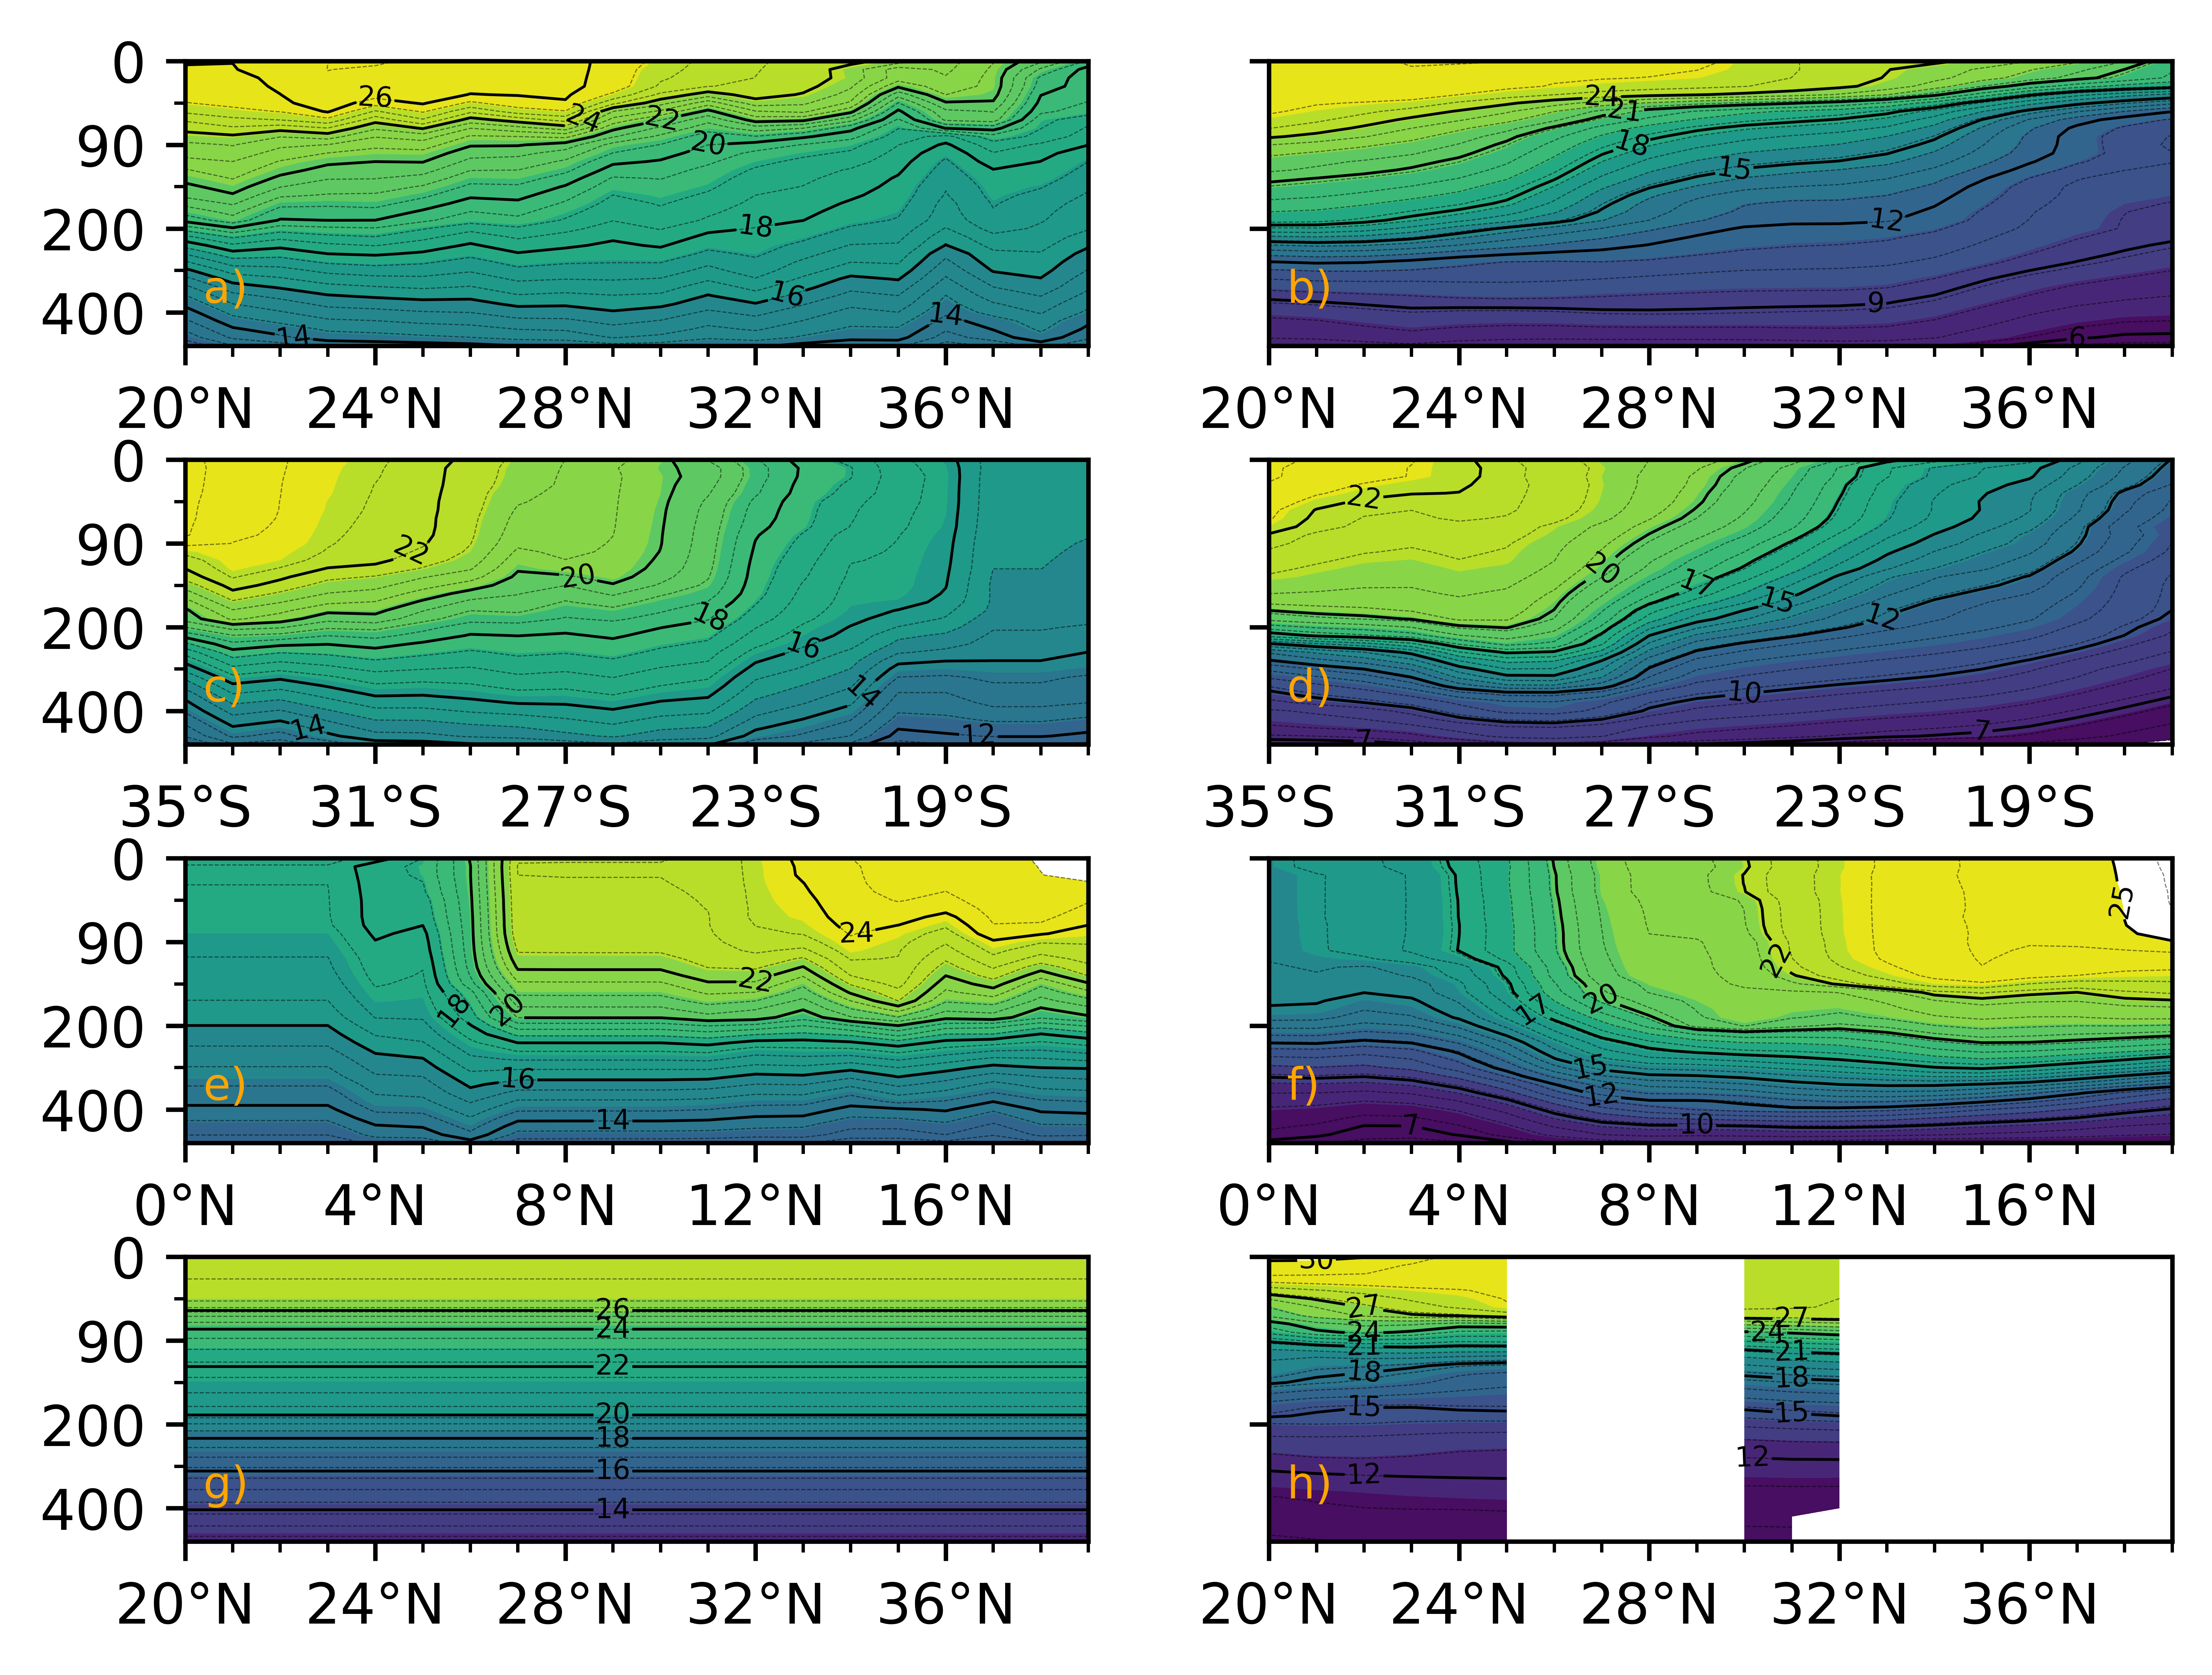

In [7]:
# 画图
from matplotlib import pyplot as plt
from src.plot.base import create_axes

axes = create_axes(4, 2)

# 调整子图间距
plt.subplots_adjust(wspace=0.2, hspace=0.4)

for i in range(4):
    area = Areas[i]
    model = modules[i]

    train_loader, val_loader, test_loader = split_dataset(area)
    
    test_input, test_output = get_input(test_loader)
    
    result = model.predict(test_input)
    
    mse_1000u, mse_1000d = rmse(result, test_output);

    list.append([reshape(result), reshape(test_output)])
    
    print(f"Area: {area['title']}, RMSE: {mse_1000u}, {mse_1000d} \n\
            origin: max = {np.nanmax(test_output)}, min = {np.nanmin(test_output)} \n\
            predict: max = {np.nanmax(result)}, min = {np.nanmin(result)}")
    
    left_index = 2 * i
    mid_index = 2 * i + 1

    ax_l, ax_r = axes[i]

    pred, origin = list[i]
    
    pred_profile = profile_u(pred)
    origin_profile = profile_u(origin.numpy())
    
    vmin = np.around(np.min([np.nanmin(pred_profile), np.nanmin(origin_profile)]), 0)
    vmax = np.around(np.max([np.nanmax(pred_profile), np.nanmax(origin_profile)]), 0)
    
    levels = np.linspace(vmin, vmax, 15)
    
    plot_sst_station(pred_profile, ax_l, levels, f"{Alphabet[left_index]})", area['lat'])
    plot_sst_station(origin_profile, ax_r, levels, f"{Alphabet[mid_index]}) ", area['lat'], ylabel=False)


In [ ]:
# --------------- 实验 2：  ---------------------------
